# 🔥 BiLSTM Model Training: Emotion Classification

This notebook trains a Bidirectional LSTM model on preprocessed emotion data using **GloVe** pre-trained embeddings.

**Embedding Strategy:** GloVe (Twitter, 200d) - captures global co-occurrence statistics that complement LSTM's long-term dependency learning.


## 📚 Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


## 📂 Load Preprocessed Data


In [8]:
# Load preprocessed training and validation data
train_df = pd.read_pickle('./data/train_preprocessed.pkl')
val_df = pd.read_pickle('./data/validation_preprocessed.pkl')

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())


Training data shape: (15999, 2)
Validation data shape: (2000, 2)

Columns: ['Text', 'Label']

First few rows:
                                                Text  Label
0                              didnt feel humiliated      0
1  go feeling hopeless damned hopeful around some...      0
2          im grabbing minute post feel greedy wrong      3
3  ever feeling nostalgic fireplace know still pr...      2
4                                    feeling grouchy      3


## 📊 Prepare Data

Split the data into features (X) and labels (y).


In [9]:
# Prepare X and y
X_train = train_df['Text']
y_train = train_df['Label']
X_val = val_df['Text']
y_val = val_df['Label']

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"\nLabel distribution in training set:")
print(y_train.value_counts().sort_index())


Training samples: 15999
Validation samples: 2000

Label distribution in training set:
Label
0    4666
1    5361
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


## 🔠 Tokenization

Convert text to sequences of integers.


In [10]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Find maximum sequence length
maxlen = max(len(tokens) for tokens in X_train_sequences)
print(f"Maximum sequence length: {maxlen}")

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=maxlen, padding='post')

print(f"\nX_train_padded shape: {X_train_padded.shape}")
print(f"X_val_padded shape: {X_val_padded.shape}")

# Calculate input size for embedding layer
input_size = np.max(X_train_padded) + 1
print(f"Vocabulary size (input_size): {input_size}")


Maximum sequence length: 35

X_train_padded shape: (15999, 35)
X_val_padded shape: (2000, 35)
Vocabulary size (input_size): 15064


## 🌐 Prepare GloVe Embeddings

Using pre-trained **GloVe** embeddings for the LSTM model. GloVe captures global co-occurrence statistics, which complements LSTM's ability to learn long-term dependencies.


In [ ]:
# Download and prepare GloVe embeddings
import gensim.downloader as api

print("📥 Downloading GloVe pre-trained embeddings (Twitter 200d)...")
print("This may take a few minutes on first run...")

# Download pre-trained GloVe model (Twitter, 200 dimensions)
# Using Twitter GloVe as it's trained on social media text (similar to emotions dataset)
glove_model = api.load('glove-twitter-200')

print("✅ GloVe embeddings loaded successfully!")

# Embedding dimension
embedding_dim = 200

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix with GloVe vectors
hits = 0
misses = 0

for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = glove_model[word]
        embedding_matrix[i] = embedding_vector
        hits += 1
    except KeyError:
        # Word not in GloVe vocabulary, leave as zeros
        misses += 1

print(f"\n📊 Embedding Matrix Statistics:")
print(f"   Vocabulary size: {vocab_size}")
print(f"   Embedding dimension: {embedding_dim}")
print(f"   Words found in GloVe: {hits}")
print(f"   Words not found (using zeros): {misses}")
print(f"   Coverage: {100 * hits / (hits + misses):.2f}%")


## 🛠️ Build BiLSTM Model

**Model Architecture:**
1. **Embedding Layer**: Pre-trained **GloVe** embeddings (200d, frozen)
   - Captures global co-occurrence statistics
   - Trained on Twitter corpus (2 billion tweets)
2. **Bidirectional LSTM**: Processes sequences in both directions (forward and backward)
3. **Batch Normalization**: Normalizes activations for stable training
4. **Dropout**: Prevents overfitting (50% dropout rate)
5. **Dense Layer**: Fully connected layer with ReLU activation
6. **Output Layer**: 6 units with softmax for emotion classification


In [ ]:
# Define the BiLSTM model with GloVe embeddings
model = Sequential()

# Embedding layer with pre-trained GloVe weights
# trainable=False keeps the embeddings frozen (transfer learning)
# Set trainable=True if you want to fine-tune embeddings during training
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False  # Keep GloVe embeddings frozen
))

# Bidirectional LSTM layer with 128 units
model.add(Bidirectional(LSTM(128)))

# Batch normalization
model.add(BatchNormalization())

# Dropout for regularization
model.add(Dropout(0.5))

# Dense layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer with 6 units (6 emotions) and softmax activation
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n🎯 Model using GloVe pre-trained embeddings (200d, frozen)")

# Display model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 35, 100)        │     1,506,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,758,758 (6.71 MB)

 Trainable params: 1,758,246 (6.71 MB)

 Non-trainable params: 512 (2.00 KB)

## 🚀 Train the Model

Train with early stopping to prevent overfitting.


In [ ]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_padded, y_val),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)


500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.6277 - loss: 1.0102 - val_accuracy: 0.6440 - val_loss: 0.9782


## 📊 Visualize Training Progress


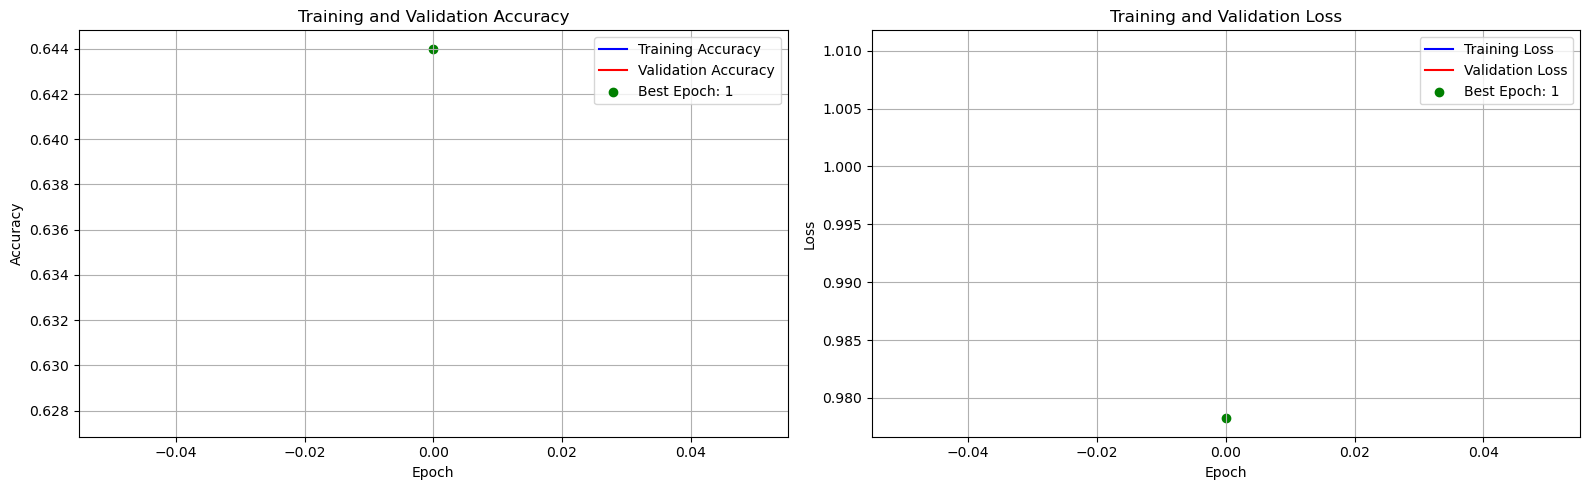

In [13]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], 
               color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], 
               color='green', label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## 📈 Evaluate Model Performance


In [14]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val_padded, y_val)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6440 - loss: 0.9782

Validation Loss: 0.9782
Validation Accuracy: 0.6440


## 🎯 Confusion Matrix


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


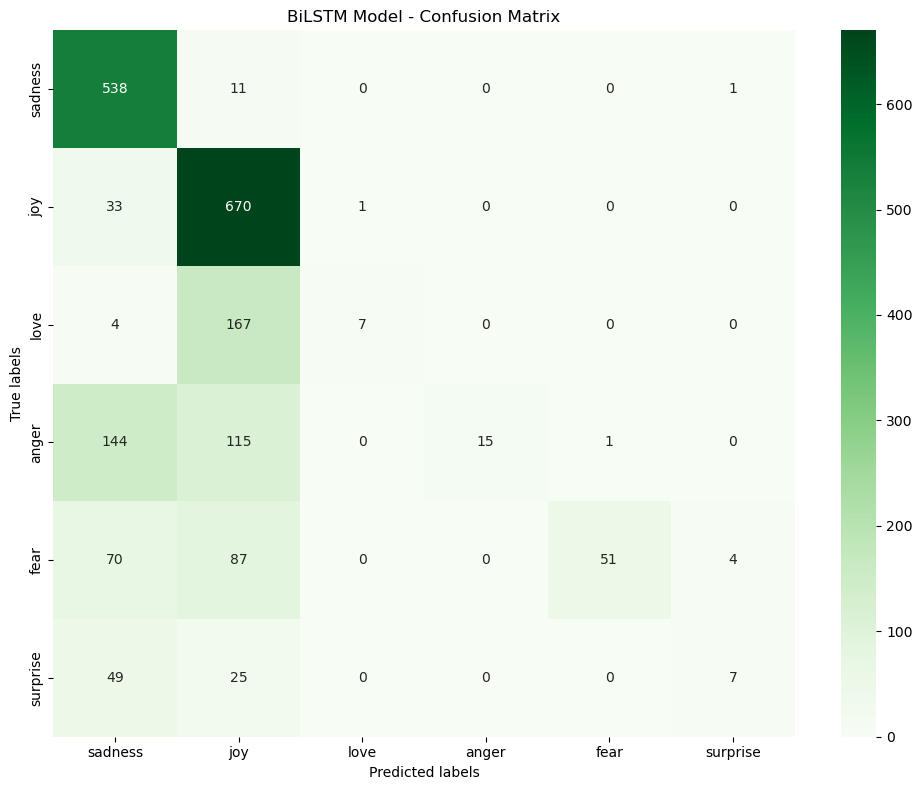

In [15]:
# Get predictions
y_val_pred = model.predict(X_val_padded)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
            yticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('BiLSTM Model - Confusion Matrix')
plt.tight_layout()
plt.show()


## 📝 Classification Report


In [16]:
# Print classification report
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=emotion_names))



Classification Report:
              precision    recall  f1-score   support

     sadness       0.64      0.98      0.78       550
         joy       0.62      0.95      0.75       704
        love       0.88      0.04      0.08       178
       anger       1.00      0.05      0.10       275
        fear       0.98      0.24      0.39       212
    surprise       0.58      0.09      0.15        81

    accuracy                           0.64      2000
   macro avg       0.78      0.39      0.37      2000
weighted avg       0.74      0.64      0.55      2000



## 🔬 Hyperparameter Tuning Experiments

Now let's systematically test different hyperparameters to understand their impact on LSTM model performance.


In [ ]:
# Function to create and train an LSTM model with custom hyperparameters
def train_lstm_model(lstm_units=128, dropout_rate=0.5, learning_rate=0.001, 
                      batch_size=32, dense_units=64, epochs=10, 
                      embedding_trainable=False, optimizer_name='adam'):
    """
    Train an LSTM model with specified hyperparameters and return validation results.
    """
    # Build model
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=embedding_trainable
    ))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    
    # Compile with specified optimizer and learning rate
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = 'adam'
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(
        X_train_padded, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_padded, y_val),
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0  # Suppress output for cleaner results
    )
    
    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_padded, y_val, verbose=0)
    
    return {
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'best_epoch': len(history.history['val_accuracy']),
        'history': history.history
    }

print("✅ Helper function defined")


### 🔍 Running All Hyperparameter Experiments

Testing: Learning Rate, Batch Size, LSTM Units, Dropout Rate, Optimizer, and Embedding Trainability


In [ ]:
import tensorflow as tf

# Experiment 1: Learning Rate
print("=" * 80)
print("EXPERIMENT 1: Learning Rate")
print("=" * 80)

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
lr_results = []

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    result = train_lstm_model(learning_rate=lr, epochs=10)
    lr_results.append({
        'learning_rate': lr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

lr_df = pd.DataFrame(lr_results)

# Experiment 2: Batch Size
print("\n" + "=" * 80)
print("EXPERIMENT 2: Batch Size")
print("=" * 80)

batch_sizes = [16, 32, 64, 128]
batch_results = []

for bs in batch_sizes:
    print(f"Testing batch size: {bs}")
    result = train_lstm_model(batch_size=bs, epochs=10)
    batch_results.append({
        'batch_size': bs,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

batch_df = pd.DataFrame(batch_results)

# Experiment 3: LSTM Units
print("\n" + "=" * 80)
print("EXPERIMENT 3: LSTM Units")
print("=" * 80)

lstm_units_list = [64, 96, 128, 192, 256]
lstm_results = []

for units in lstm_units_list:
    print(f"Testing LSTM units: {units}")
    result = train_lstm_model(lstm_units=units, epochs=10)
    lstm_results.append({
        'lstm_units': units,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

lstm_df = pd.DataFrame(lstm_results)

# Experiment 4: Dropout Rate
print("\n" + "=" * 80)
print("EXPERIMENT 4: Dropout Rate")
print("=" * 80)

dropout_rates = [0.2, 0.3, 0.4, 0.5, 0.6]
dropout_results = []

for dr in dropout_rates:
    print(f"Testing dropout rate: {dr}")
    result = train_lstm_model(dropout_rate=dr, epochs=10)
    dropout_results.append({
        'dropout_rate': dr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

dropout_df = pd.DataFrame(dropout_results)

# Experiment 5: Optimizer
print("\n" + "=" * 80)
print("EXPERIMENT 5: Optimizer")
print("=" * 80)

optimizers = ['adam', 'rmsprop', 'sgd']
opt_results = []

for opt in optimizers:
    print(f"Testing optimizer: {opt}")
    result = train_lstm_model(optimizer_name=opt, epochs=10)
    opt_results.append({
        'optimizer': opt,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

opt_df = pd.DataFrame(opt_results)

# Experiment 6: Embedding Trainability
print("\n" + "=" * 80)
print("EXPERIMENT 6: Embedding Trainability")
print("=" * 80)

emb_configs = [False, True]
emb_labels = ['Frozen', 'Fine-tuned']
emb_results = []

for trainable, label in zip(emb_configs, emb_labels):
    print(f"Testing: {label} embeddings")
    result = train_lstm_model(embedding_trainable=trainable, epochs=10)
    emb_results.append({
        'configuration': label,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

emb_df = pd.DataFrame(emb_results)

print("\n✅ All experiments completed!")


### 📊 Comprehensive Hyperparameter Tuning Summary

Visualize and compare all hyperparameter experiment results.


In [ ]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Learning Rate
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(lr_df['learning_rate'], lr_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Val Accuracy')
ax1.set_title('Learning Rate Impact')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
best_lr_idx = lr_df['val_accuracy'].idxmax()
ax1.scatter(lr_df.loc[best_lr_idx, 'learning_rate'], lr_df.loc[best_lr_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 2: Batch Size
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(batch_df['batch_size'], batch_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Val Accuracy')
ax2.set_title('Batch Size Impact')
ax2.grid(True, alpha=0.3)
best_batch_idx = batch_df['val_accuracy'].idxmax()
ax2.scatter(batch_df.loc[best_batch_idx, 'batch_size'], batch_df.loc[best_batch_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 3: LSTM Units
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(lstm_df['lstm_units'], lstm_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='purple')
ax3.set_xlabel('LSTM Units')
ax3.set_ylabel('Val Accuracy')
ax3.set_title('LSTM Units Impact')
ax3.grid(True, alpha=0.3)
best_lstm_idx = lstm_df['val_accuracy'].idxmax()
ax3.scatter(lstm_df.loc[best_lstm_idx, 'lstm_units'], lstm_df.loc[best_lstm_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 4: Dropout Rate
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(dropout_df['dropout_rate'], dropout_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='teal')
ax4.set_xlabel('Dropout Rate')
ax4.set_ylabel('Val Accuracy')
ax4.set_title('Dropout Rate Impact')
ax4.grid(True, alpha=0.3)
best_dropout_idx = dropout_df['val_accuracy'].idxmax()
ax4.scatter(dropout_df.loc[best_dropout_idx, 'dropout_rate'], dropout_df.loc[best_dropout_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 5: Optimizer
ax5 = fig.add_subplot(gs[1, 1])
ax5.bar(opt_df['optimizer'], opt_df['val_accuracy'], color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
ax5.set_xlabel('Optimizer')
ax5.set_ylabel('Val Accuracy')
ax5.set_title('Optimizer Impact')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Embedding Trainability
ax6 = fig.add_subplot(gs[1, 2])
ax6.bar(emb_df['configuration'], emb_df['val_accuracy'], color=['#9b59b6', '#1abc9c'], edgecolor='black', linewidth=2)
ax6.set_xlabel('Embedding Mode')
ax6.set_ylabel('Val Accuracy')
ax6.set_title('Embedding Trainability Impact')
ax6.grid(True, alpha=0.3, axis='y')

# Create summary data
summary_data = []
summary_data.append({
    'Hyperparameter': 'Learning Rate',
    'Best Value': f"{lr_df.loc[lr_df['val_accuracy'].idxmax(), 'learning_rate']}",
    'Val Accuracy': lr_df['val_accuracy'].max(),
    'Val Loss': lr_df.loc[lr_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Batch Size',
    'Best Value': f"{int(batch_df.loc[batch_df['val_accuracy'].idxmax(), 'batch_size'])}",
    'Val Accuracy': batch_df['val_accuracy'].max(),
    'Val Loss': batch_df.loc[batch_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'LSTM Units',
    'Best Value': f"{int(lstm_df.loc[lstm_df['val_accuracy'].idxmax(), 'lstm_units'])}",
    'Val Accuracy': lstm_df['val_accuracy'].max(),
    'Val Loss': lstm_df.loc[lstm_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Dropout Rate',
    'Best Value': f"{dropout_df.loc[dropout_df['val_accuracy'].idxmax(), 'dropout_rate']}",
    'Val Accuracy': dropout_df['val_accuracy'].max(),
    'Val Loss': dropout_df.loc[dropout_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Optimizer',
    'Best Value': opt_df.loc[opt_df['val_accuracy'].idxmax(), 'optimizer'],
    'Val Accuracy': opt_df['val_accuracy'].max(),
    'Val Loss': opt_df.loc[opt_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Embedding Mode',
    'Best Value': emb_df.loc[emb_df['val_accuracy'].idxmax(), 'configuration'],
    'Val Accuracy': emb_df['val_accuracy'].max(),
    'Val Loss': emb_df.loc[emb_df['val_accuracy'].idxmax(), 'val_loss']
})

summary_df = pd.DataFrame(summary_data)

# Plot 7: Summary Bar Chart (spanning bottom row)
ax7 = fig.add_subplot(gs[2, :])
colors = plt.cm.viridis(np.linspace(0, 1, len(summary_df)))
bars = ax7.barh(summary_df['Hyperparameter'], summary_df['Val Accuracy'], color=colors, edgecolor='black', linewidth=2)
ax7.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax7.set_title('Best Validation Accuracy for Each Hyperparameter', fontsize=14, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')
for bar, val, best_val in zip(bars, summary_df['Val Accuracy'], summary_df['Best Value']):
    ax7.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f} ({best_val})', va='center', fontweight='bold')

plt.suptitle('LSTM Model - Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print summary table
print("\n" + "=" * 80)
print("🏆 HYPERPARAMETER TUNING RESULTS SUMMARY - LSTM MODEL")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

# Print recommendations
print("\n" + "=" * 80)
print("💡 RECOMMENDATIONS FOR OPTIMAL LSTM MODEL")
print("=" * 80)
for i, row in summary_df.iterrows():
    print(f"{row['Hyperparameter']:20s} {row['Best Value']}")
print("=" * 80)
print(f"\n🎯 Expected Validation Accuracy: {summary_df['Val Accuracy'].max():.4f}")
print(f"📉 Expected Validation Loss:     {summary_df['Val Loss'].min():.4f}")


## 💾 Save Model and Tokenizer

Save the trained model and tokenizer for later use.


In [17]:
# Save the model
model.save('./data/lstm/lstm_model.keras')
print("✅ Model saved to: ./data/lstm/lstm_model.keras")

# Save the tokenizer
with open('./data/lstm/lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved to: ./data/lstm/lstm_tokenizer.pkl")

# Save training metadata
metadata = {
    'maxlen': maxlen,
    'input_size': input_size,
    'val_accuracy': val_accuracy,
    'val_loss': val_loss,
    'best_epoch': best_epoch
}

with open('./data/lstm/lstm_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("✅ Metadata saved to: ./data/lstm/lstm_metadata.pkl")

print(f"\n{'='*60}")
print("BiLSTM MODEL TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


✅ Model saved to: ./data/lstm/lstm_model.keras
✅ Tokenizer saved to: ./data/lstm/lstm_tokenizer.pkl
✅ Metadata saved to: ./data/lstm/lstm_metadata.pkl

BiLSTM MODEL TRAINING COMPLETE!
Final Validation Accuracy: 0.6440
Final Validation Loss: 0.9782
